/home/hdwang/.conda/envs/mdanalysis/lib/python3.14/site-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/home/hdwang/.conda/envs/mdanalysis/lib/python3.14/site-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


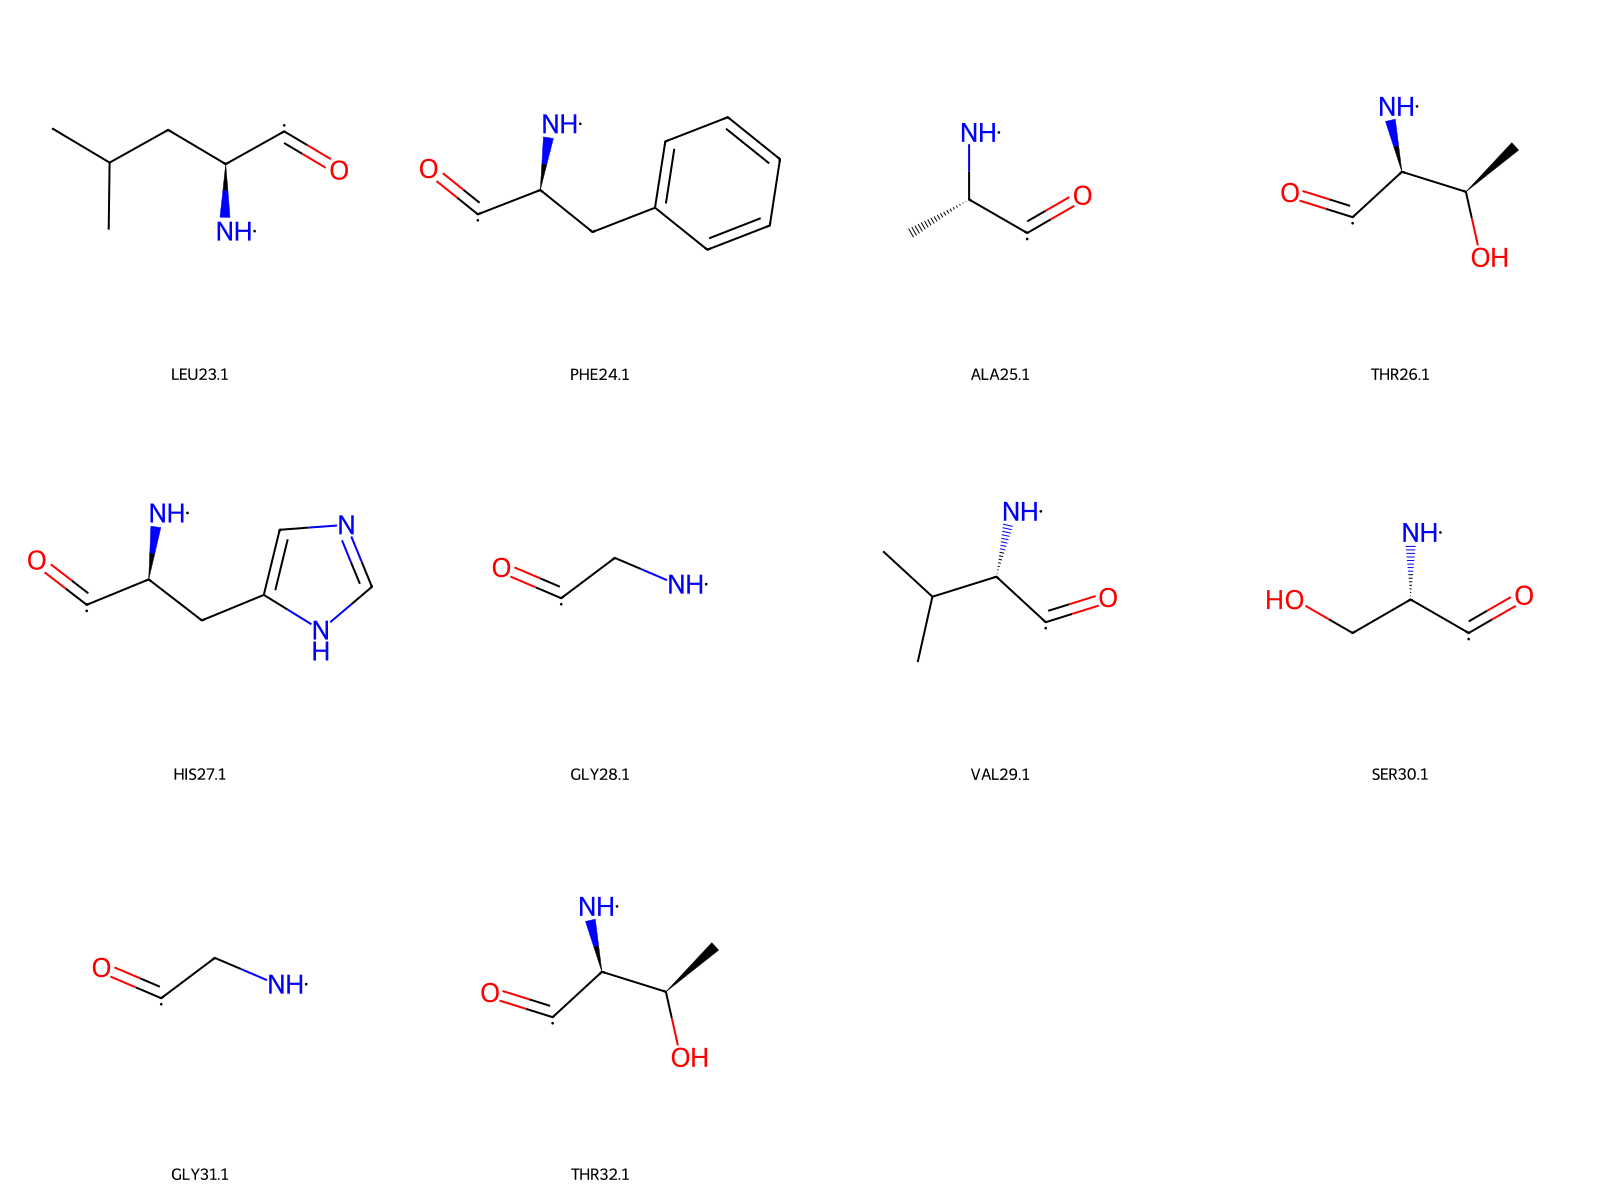

In [2]:
import MDAnalysis as mda
import prolif as plf


# 1. Load the trajectory and topology
u = mda.Universe("/home/hdwang/sensor_hd/202601/MD4TF/MD4ATF_results_repeat1/AcrR_TES/06_Production_MD/trajectory.pdb", "/home/hdwang/sensor_hd/202601/MD4TF/MD4ATF_results_repeat1/AcrR_TES/06_Production_MD/trajectory.dcd")

# 2. Create a Prolif object, use tes as example ligand
ligand_sele = u.select_atoms("resname TES")
protein_sele = u.select_atoms("protein")

## if the protein size is too large, you can use the following code to select the protein residues
protein_sur_sele = u.select_atoms("protein and byres (around 20.0 (resname TES))")
# 3. Create a molecule from the MDanalysis selection
ligand_sele.guess_bonds()
ligand_mol = plf.Molecule.from_mda(ligand_sele)

# show the molecule
plf.display_residues(ligand_mol, size=(400, 400))

# or we can show the residues in the protein 
protein_sele.guess_bonds()
protein_sele.guess_bonds(vdwradii={"H": 1.05, "O": 1.48})

protein_mol = plf.Molecule.from_mda(protein_sur_sele)
plf.display_residues(protein_mol, slice(10, 20), size=(400, 400))



In [3]:
# 4. Create a Prolif object, use est as example ligand, count=True will count the number of each type of fingerprint
# vicinity_cutoff=7.0, default is 6.0 Angstrom
plf.Fingerprint.list_available()

fp = plf.Fingerprint(vicinity_cutoff=7.0)

# run on a slice of the trajectory frames: from begining to end with a step of 100

fp.run(u.trajectory[:: 10], ligand_sele,protein_sele)



  0%|          | 0/100 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x77623b42c590>

{0: {(ResidueId(TES, 384, 1), ResidueId(GLN, 97, 1)): {'Hydrophobic': ({'indices': {'ligand': (42,), 'protein': (4,)}, 'parent_indices': {'ligand': (42,), 'protein': (1403,)}, 'distance': 3.865822741425853},)}, (ResidueId(TES, 384, 1), ResidueId(LEU, 108, 1)): {'Hydrophobic': ({'indices': {'ligand': (33,), 'protein': (13,)}, 'parent_indices': {'ligand': (33,), 'protein': (1601,)}, 'distance': 3.9629616086068666},)}, (ResidueId(TES, 384, 1), ResidueId(ILE, 70, 1)): {'Hydrophobic': ({'indices': {'ligand': (43,), 'protein': (13,)}, 'parent_indices': {'ligand': (43,), 'protein': (1008,)}, 'distance': 4.265058760329384},)}, (ResidueId(TES, 384, 1), ResidueId(LEU, 152, 1)): {'Hydrophobic': ({'indices': {'ligand': (27,), 'protein': (4,)}, 'parent_indices': {'ligand': (27,), 'protein': (2273,)}, 'distance': 4.397324392290772},), 'VdWContact': ({'indices': {'ligand': (26,), 'protein': (14,)}, 'parent_indices': {'ligand': (26,), 'protein': (2283,)}, 'distance': 2.1185381572747595},)}, (ResidueId

<Axes: xlabel='Frame'>

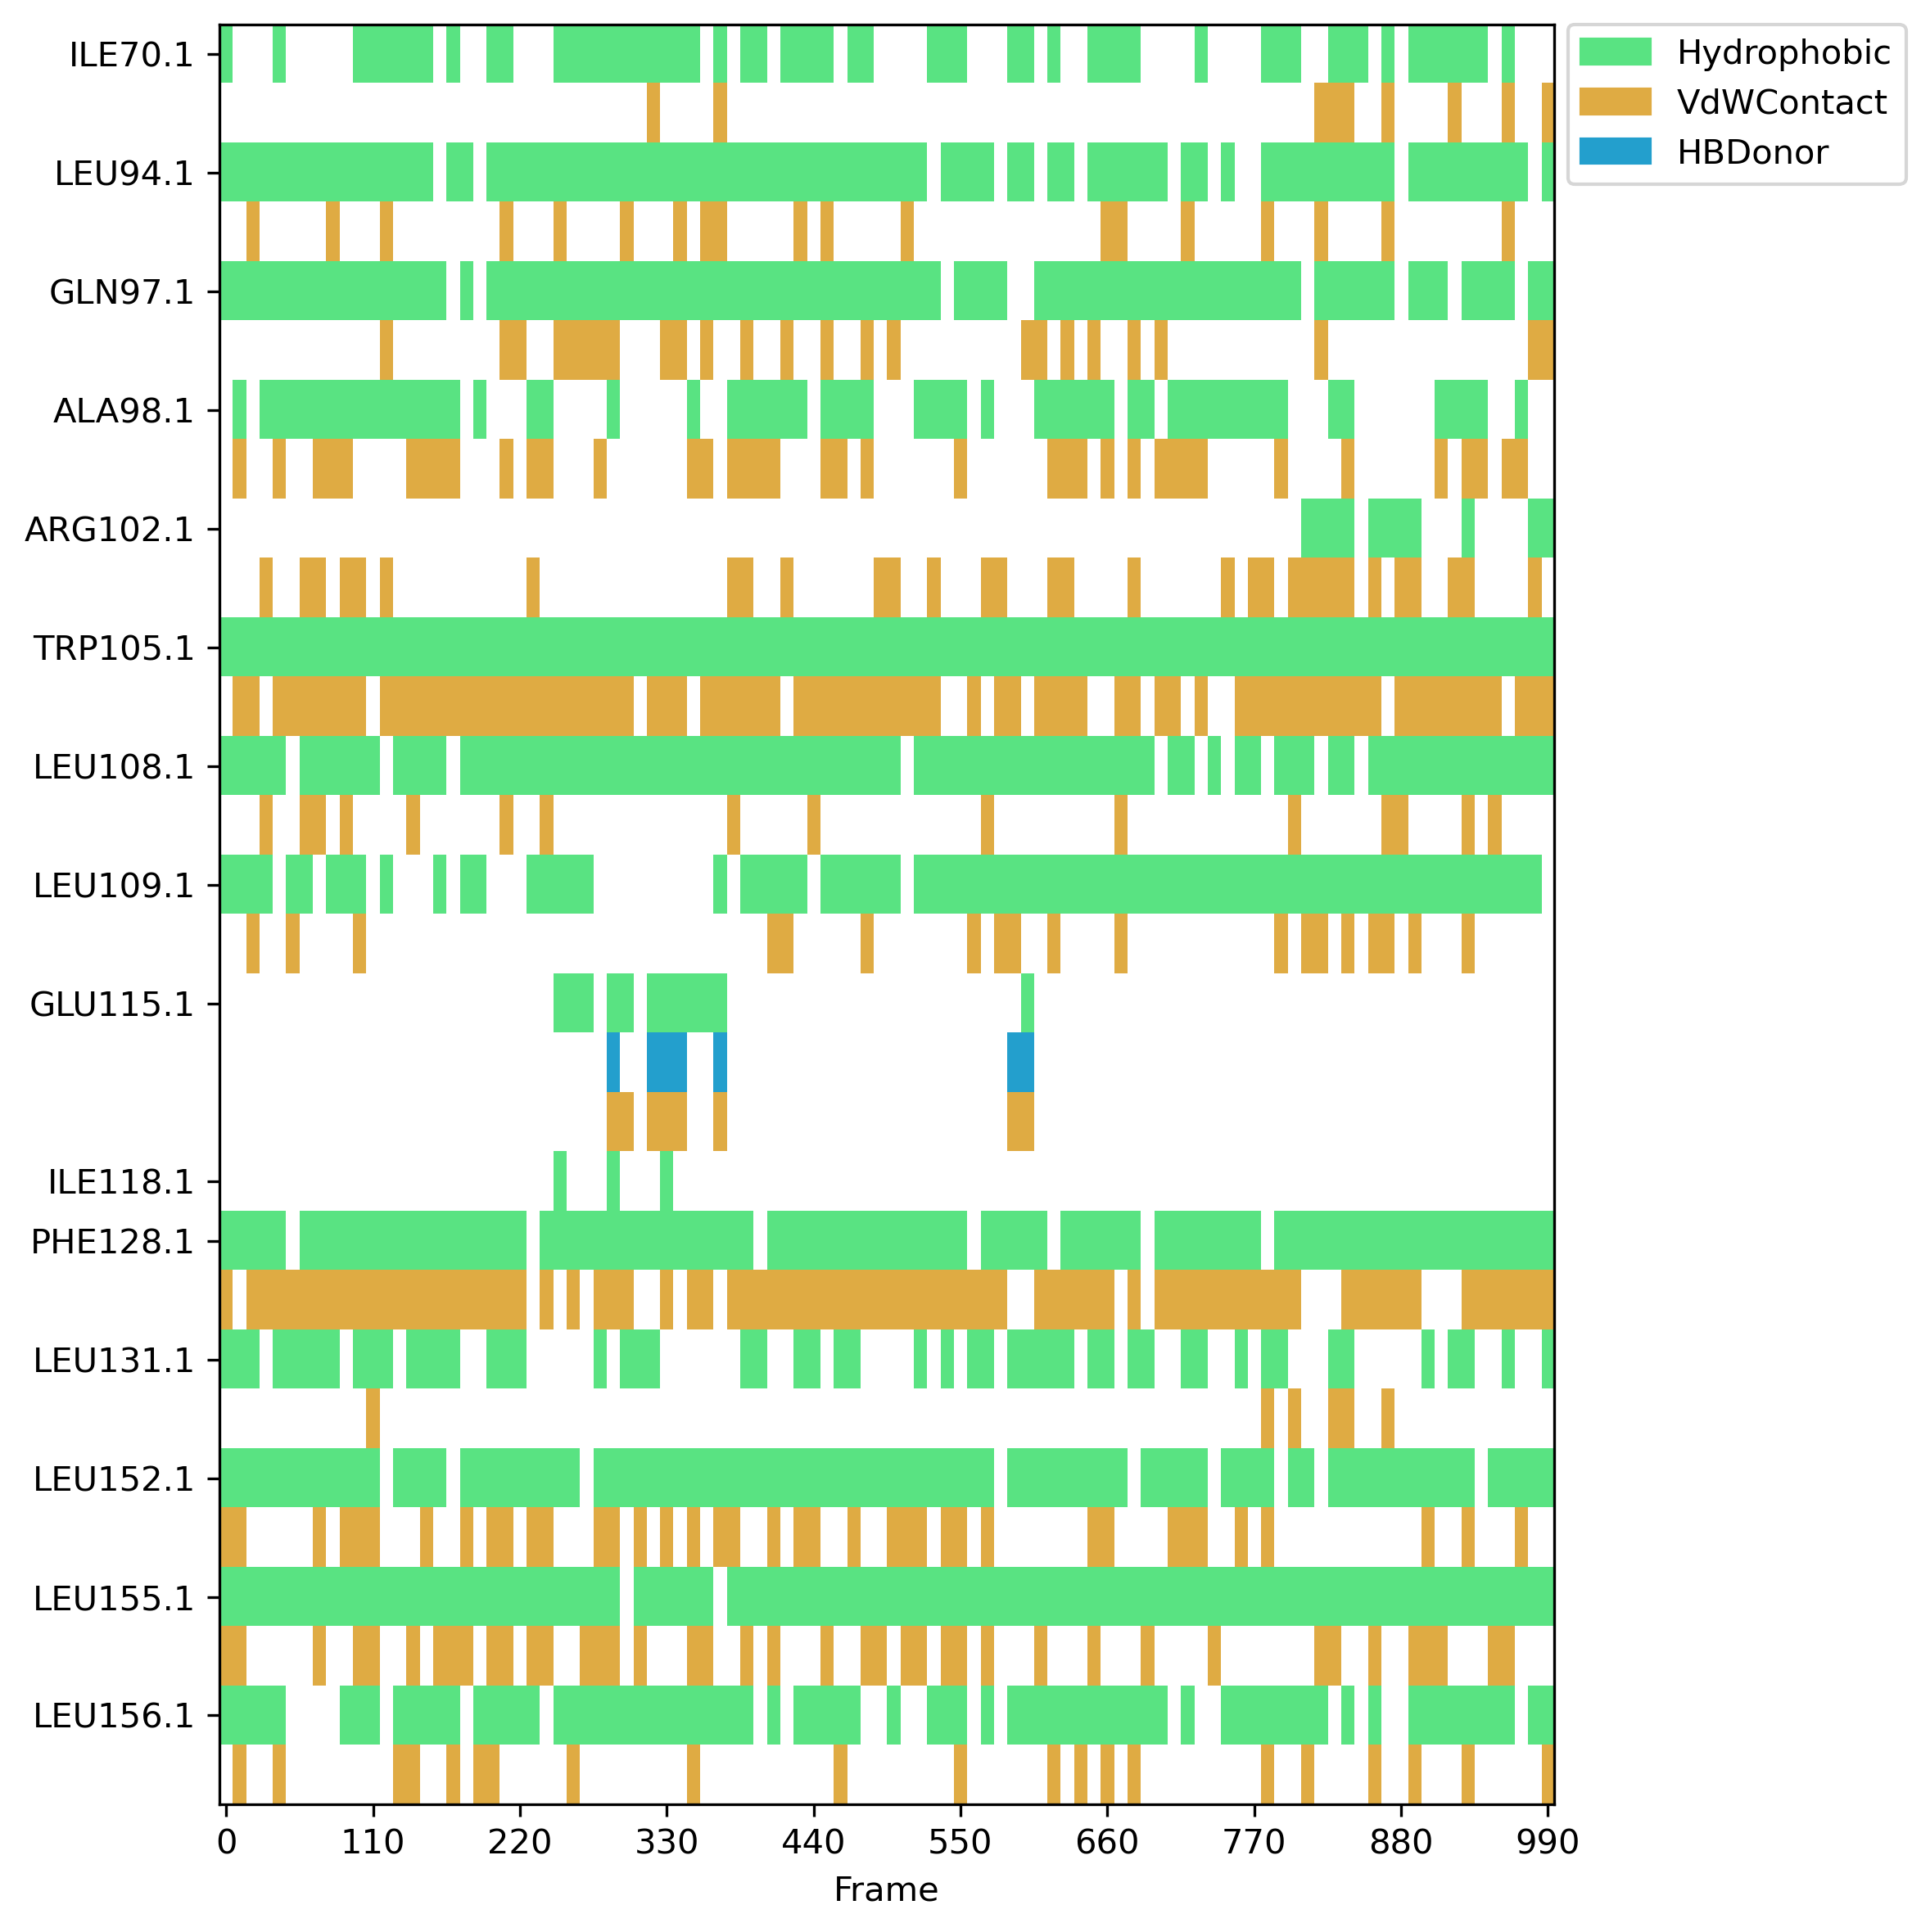

In [4]:
# 5. the result is stored in the fingerprint object
fp.to_pickle("fingerprint_WT_AcrR_TES_model_0.pkl")

# load it again
fp = plf.Fingerprint.from_pickle("fingerprint_WT_AcrR_TES_model_0.pkl")

frame_sele = 0
print(fp.ifp)
df = fp.to_dataframe()

fp.plot_barcode(dpi=300, figsize=(8, 8))


In [5]:
# threshold=0.5 means only show the 50 %  shown in the whole frames
fp.plot_lignetwork(ligand_mol, threshold=0.5)


Again showing the rmsf

In [ ]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt

def cal_rmsf(topology, trajectory):
    u = mda.Universe(topology, trajectory, topology_format="PDB", trajectory_format="DCD")

    # Build an average CA structure and align all frames to it
    average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
    ref = average.results.universe
    align.AlignTraj(u, ref, select="protein and name CA", in_memory=True).run()

    # Select CA atoms per chain (ensure your PDB has segids A and B; see notes below)
    c_alphas_A = u.select_atoms('protein and name CA and segid A')
    c_alphas_B = u.select_atoms('protein and name CA and segid B')

    R_A = rms.RMSF(c_alphas_A).run()
    R_B = rms.RMSF(c_alphas_B).run()
    return R_A, R_B, c_alphas_A, c_alphas_B

pdb = "/home/hdwang/sensor_hd/202601/MD4TF/MD4ATF_results_repeat1/AcrR_TES/06_Production_MD/trajectory.pdb"
dcd = "/home/hdwang/sensor_hd/202601/MD4TF/MD4ATF_results_repeat1/AcrR_TES/06_Production_MD/trajectory.dcd"

R_A, R_B, c_alphas_A, c_alphas_B = cal_rmsf(pdb, dcd)

# Wrap into arrays so downstream code works for single or multiple runs
rmsfs_A = np.array([R_A.rmsf])
rmsfs_B = np.array([R_B.rmsf])

average_rmsf_A = np.mean(rmsfs_A, axis=0)
average_rmsf_B = np.mean(rmsfs_B, axis=0)

fig, ax = plt.subplots()
ax.plot(c_alphas_A.resids, average_rmsf_A, label='Chain A')
ax.plot(c_alphas_B.resids, average_rmsf_B, label='Chain B')

# Shaded range (will collapse to a line for single trajectory)
ax.fill_between(c_alphas_A.resids, np.min(rmsfs_A, axis=0), np.max(rmsfs_A, axis=0), color='blue', alpha=0.3)
ax.fill_between(c_alphas_B.resids, np.min(rmsfs_B, axis=0), np.max(rmsfs_B, axis=0), color='orange', alpha=0.3)

plt.xlabel('Residue number', fontsize=22)
plt.ylabel('RMSF ($ \\AA $)', fontsize=22)
plt.title('RMSF of AAcrR_EST', fontsize=22)
ax.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('AAcrR_EST_rmsf.png')
plt.show()


reaveling most dynamic region according to the rmsd value

Highlight the region of flexible using RMSD and RMSF

In [2]:
import os
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import matplotlib.pyplot as plt

def single_chain_rmsd_rmsf(topology, trajectory, sel_str='protein and name CA', in_memory=True):
    u = mda.Universe(topology, trajectory)
    if u.trajectory.n_frames < 2:
        raise ValueError(f"Trajectory {trajectory} has fewer than 2 frames.")
    sel = u.select_atoms(sel_str)
    if sel.n_atoms == 0:
        raise ValueError(f"Selection returned 0 atoms: {sel_str} for {topology}")

    # Build average reference and align trajectory to it
    avg = align.AverageStructure(u, u, select=sel_str, ref_frame=0).run()
    ref = avg.results.universe
    align.AlignTraj(u, ref, select=sel_str, in_memory=in_memory).run()

    # RMSD vs time
    R = rms.RMSD(u, ref, select=sel_str).run()
    arr = R.results.rmsd
    # Time column (if available) and RMSD column (last)
    if arr.shape[1] >= 2:
        times = arr[:, 1]
    else:
        dt = u.trajectory.dt if getattr(u.trajectory, "dt", None) else 1.0
        times = np.arange(arr.shape[0]) * dt
    rmsd = arr[:, -1]

    # RMSF for the selection
    F = rms.RMSF(sel).run()
    rmsf = F.results.rmsf

    return times, rmsd, rmsf, sel

# ---------------------------------------------------------------------
# Set up your three repeats
# Option A: three "copies" under the same parent folder
base = "/home/hdwang/sensor_hd/202601/MD4TF/MD4ATF_results_repeat1"
repeats = [
    os.path.join(base, f"AcrR_TEScopy{i}", "06_Production_MD")
    for i in (1, 2, 3)
]
pdb_files = [os.path.join(p, "trajectory.pdb") for p in repeats]
dcd_files = [os.path.join(p, "trajectory.dcd") for p in repeats]

# If instead you have repeat1/2/3 as separate top-level folders, use:
# bases = [
#   "/path/to/MD4ATF_results_repeat1",
#   "/path/to/MD4ATF_results_repeat2",
#   "/path/to/MD4ATF_results_repeat3",
# ]

# ---------------------------------------------------------------------
# Run analysis
sel_str = 'protein and name CA'  # or 'backbone'
results = []
for i, (pdb, dcd) in enumerate(zip(pdb_files, dcd_files), start=1):
    try:
        times, rmsd, rmsf, sel = single_chain_rmsd_rmsf(pdb, dcd, sel_str=sel_str, in_memory=True)
        results.append(dict(label=f"repeat{i}", pdb=pdb, dcd=dcd,
                            times=times, rmsd=rmsd, rmsf=rmsf, n_sel=sel.n_atoms))
        print(f"repeat{i}: frames={len(times)}, selection atoms={sel.n_atoms}")
    except Exception as e:
        print(f"repeat{i} failed: {e}")

# ---------------------------------------------------------------------
# Aggregate across repeats (if compatible)
def _all_equal_shapes(arrs):
    return len(arrs) > 0 and all(a.shape == arrs[0].shape for a in arrs)

# RMSF aggregation needs equal length and ordering (same atom selection/order)
rmsf_arrays = [r["rmsf"] for r in results]
rmsf_mean = rmsf_std = None
if _all_equal_shapes(rmsf_arrays):
    rmsf_stack = np.vstack(rmsf_arrays)
    rmsf_mean = rmsf_stack.mean(axis=0)
    rmsf_std = rmsf_stack.std(axis=0)
else:
    print("RMSF arrays differ in length/order; skipping averaged RMSF.")

# RMSD aggregation requires matching time vectors
rmsd_arrays = [r["rmsd"] for r in results]
time_arrays = [r["times"] for r in results]
rmsd_mean = rmsd_std = time_common = None
if _all_equal_shapes(time_arrays) and all(np.allclose(time_arrays[0], t) for t in time_arrays[1:]):
    time_common = time_arrays[0]
    rmsd_stack = np.vstack(rmsd_arrays)
    rmsd_mean = rmsd_stack.mean(axis=0)
    rmsd_std = rmsd_stack.std(axis=0)
else:
    print("Time vectors differ; skipping averaged RMSD.")



/home/hdwang/.conda/envs/mdanalysis/lib/python3.14/site-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/home/hdwang/.conda/envs/mdanalysis/lib/python3.14/site-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


repeat1: frames=999, selection atoms=382
repeat2: frames=999, selection atoms=382
repeat3: frames=999, selection atoms=382


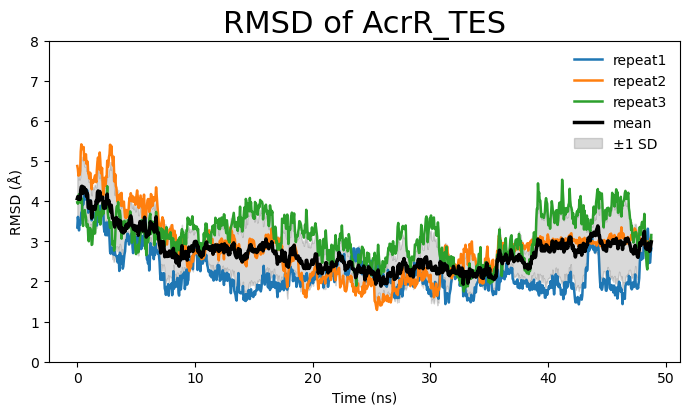

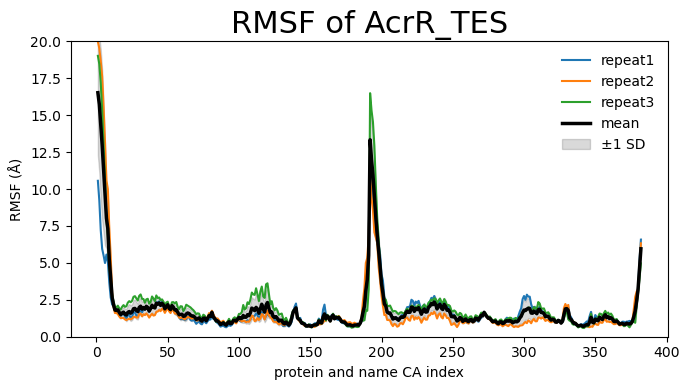

In [3]:
# ---------------------------------------------------------------------
# Plotting
# RMSD per repeat
plt.figure(figsize=(7, 4))
for r in results:
    plt.plot(r["times"], r["rmsd"], lw=1.8, label=r["label"])
if time_common is not None and rmsd_mean is not None:
    plt.plot(time_common, rmsd_mean, 'k', lw=2.5, label="mean")
    if rmsd_std is not None:
        plt.fill_between(time_common, rmsd_mean - rmsd_std, rmsd_mean + rmsd_std,
                         color='k', alpha=0.15, label="±1 SD")
plt.xlabel("Time (ns)")
plt.ylabel("RMSD (Å)")

# set ytick and range from 0 to 8, small ticks every 1 unit
plt.ylim(0, 8)
plt.yticks(np.arange(0, 9, 1))


plt.legend(frameon=False)
plt.tight_layout()
plt.title('RMSD of AcrR_TES', fontsize=22)

# RMSF per repeat (indexed by atom order because residue IDs are missing)
plt.figure(figsize=(7, 4))
for r in results:
    x = np.arange(1, r["rmsf"].shape[0] + 1)
    plt.plot(x, r["rmsf"], lw=1.5, label=r["label"])
if rmsf_mean is not None:
    x = np.arange(1, rmsf_mean.shape[0] + 1)
    plt.plot(x, rmsf_mean, 'k', lw=2.5, label="mean")
    if rmsf_std is not None:
        plt.fill_between(x, rmsf_mean - rmsf_std, rmsf_mean + rmsf_std, color='k', alpha=0.15, label="±1 SD")
plt.xlabel(f"{sel_str} index")
plt.ylabel("RMSF (Å)")
plt.legend(frameon=False)

# set ytick and range from 0 to 8, small ticks every 1 unit
plt.ylim(0, 20)
plt.yticks(np.arange(0,21, 2.5))

# add title
plt.title('RMSF of AcrR_TES', fontsize=22)
plt.tight_layout()
plt.show()

# Optionally: save arrays
outdir = "./rms_outputs"
os.makedirs(outdir, exist_ok=True)
for r in results:
    tag = r["label"]
    np.save(os.path.join(outdir, f"{tag}_times.npy"), r["times"])
    np.save(os.path.join(outdir, f"{tag}_rmsd.npy"), r["rmsd"])
    np.save(os.path.join(outdir, f"{tag}_rmsf.npy"), r["rmsf"])
if time_common is not None and rmsd_mean is not None:
    np.save(os.path.join(outdir, "rmsd_mean.npy"), rmsd_mean)
    np.save(os.path.join(outdir, "rmsd_std.npy"), rmsd_std)
if rmsf_mean is not None:
    np.save(os.path.join(outdir, "rmsf_mean.npy"), rmsf_mean)
    np.save(os.path.join(outdir, "rmsf_std.npy"), rmsf_std)


In [21]:
# filtering the top flexible residues into a df_30.csv file
import os
import pandas as pd

rmsf_csv = '/home/hdwang/sensor_hd/202601/MD4TF/MD4ATF_results_repeat1/rms_outputs/per_residue_relative_dynamics.csv'

df = pd.read_csv(rmsf_csv)

# sort by rmsf_mean descending
df_sorted = df.sort_values(by='rmsf_mean', ascending=False)

# only comparing the half chain, from1 to 191
df_half = df_sorted[df_sorted['residue_index'] <= 191]
# select top 30 residues
df_top30 = df_half.head(30)
df_top30.to_csv('df_A_30.csv', index=False)